In [9]:
!git clone https://github.com/misbah4064/emotion_recognition.git
%cd emotion_recognition

Cloning into 'emotion_recognition'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 0), reused 13 (delta 0), pack-reused 0
Receiving objects: 100% (14/14), 8.89 MiB | 26.92 MiB/s, done.
/content/emotion_recognition/emotion_recognition/emotion_recognition


In [10]:
pip install mtcnn

1/1 [==============================] - 0s 65ms/step


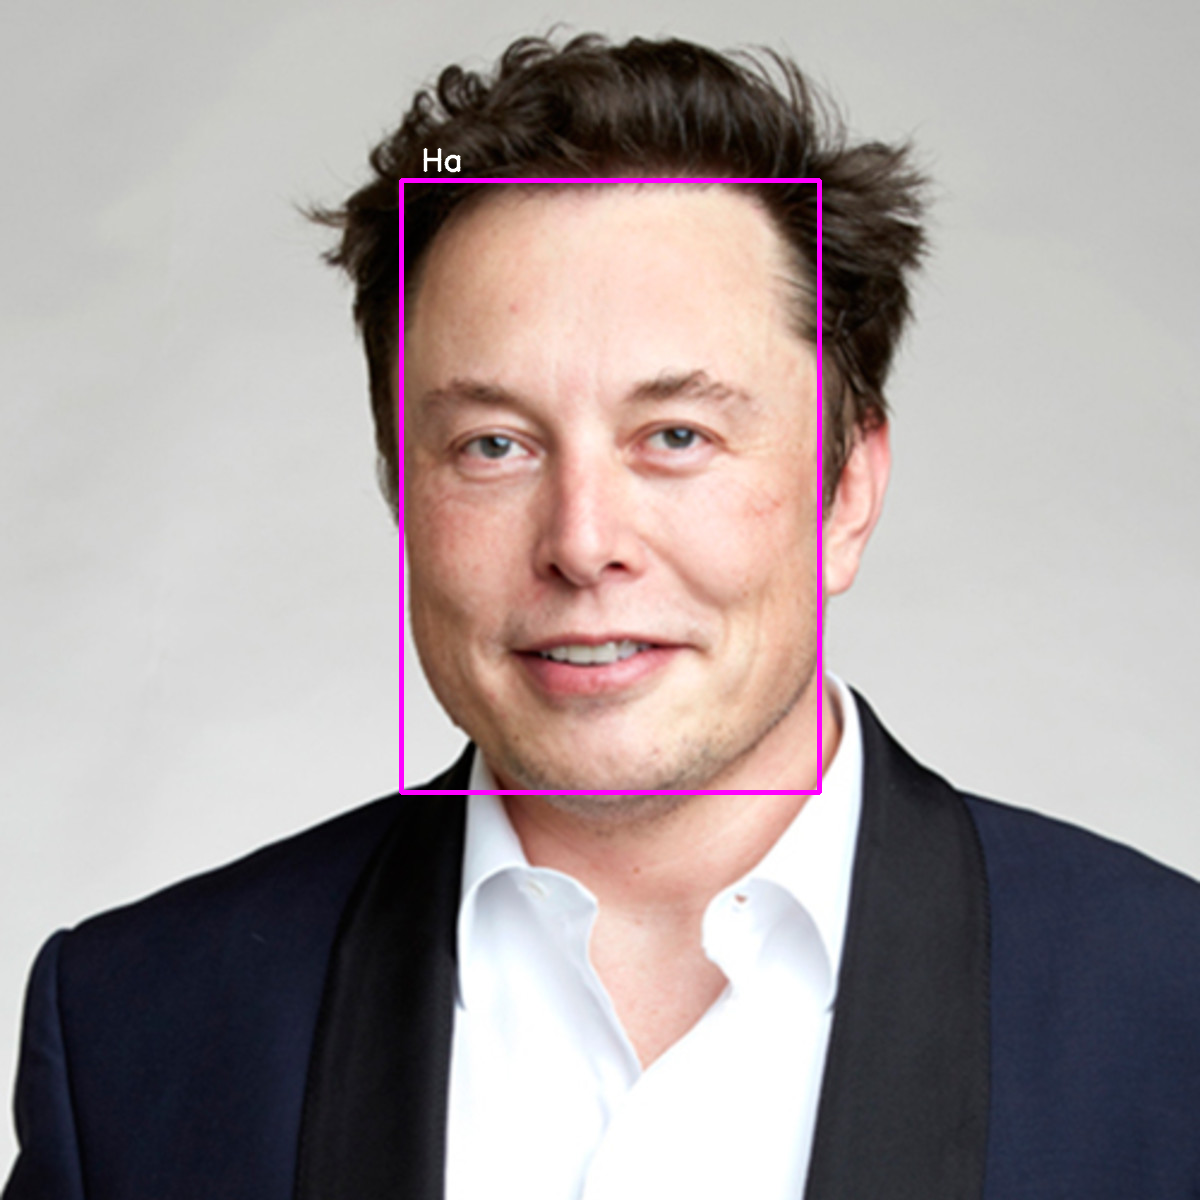

In [12]:
import numpy as np
import pandas as pd
import cv2
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Load the pre-trained model weights
model.load_weights('model.h5')

# Dictionary which assigns each label an emotion (alphabetical order)
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# Keep track of previously drawn boxes
prev_boxes = []

# Face detection using MTCNN
def detect_faces(frame):
    detector = MTCNN()
    faces = detector.detect_faces(frame)
    return faces

# Preprocess the image
def preprocess_image(image):
    if len(image.shape) > 2 and image.shape[-1] == 3:
        # Convert BGR image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image  # Already grayscale

    resized_image = cv2.resize(gray_image, (48, 48))
    normalized_image = resized_image / 255.0
    reshaped_image = np.reshape(normalized_image, (1, 48, 48, 1))
    return reshaped_image

# Predict facial expressions
def predict_emotions(frame):
    global prev_boxes
    faces = detect_faces(frame)

    face_count = len(faces)
    attentive_count = 0
    non_attentive_count = 0

    for face in faces:
        x, y, w, h = face['box']
        new_box = [x, y, x + w, y + h]  # Coordinates of the new box

        # Check if the new box overlaps with any of the previous boxes
        overlapping = False
        for box in prev_boxes:
            if check_overlap(new_box, box):
                overlapping = True
                break

        if not overlapping:
            # Draw the box around the face
            cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 255), 3)
            roi_gray = frame[y:y + h, x:x + w]
            preprocessed_img = preprocess_image(roi_gray)
            prediction = model.predict(preprocessed_img)
            max_index = int(np.argmax(prediction))
            emotion_label = emotion_dict[max_index][:2]  # Take the first two letters of the emotion
            cv2.putText(frame, emotion_label, (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            # Check if the face is attentive or not (example condition, modify as needed)
            if emotion_label in ["Ha", "Ne", "Su"]:
                attentive_count += 1
            else:
                non_attentive_count += 1

            prev_boxes.append(new_box)

    return frame, face_count, attentive_count, non_attentive_count

# Helper function to check if two boxes overlap
def check_overlap(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2

    if x2 < x3 or x1 > x4:
        return False
    if y2 < y3 or y1 > y4:
        return False
    return True

# Save the counts to an Excel file
def save_counts_to_excel(face_count, attentive_count, non_attentive_count):
    data = {'Face Count': [face_count], 'Attentive Count': [attentive_count], 'Non-Attentive Count': [non_attentive_count]}
    df = pd.DataFrame(data)
    df.to_excel('emotion_results.xlsx', index=False)

# Main function for emotion recognition
def emotion_recognition(frame):
    output_frame, face_count, attentive_count, non_attentive_count = predict_emotions(frame)
    save_counts_to_excel(face_count, attentive_count, non_attentive_count)
    return output_frame

from google.colab.patches import cv2_imshow

# Test the code with an input image
input_image = cv2.imread("elon.jpg")
output_image = emotion_recognition(input_image)
cv2_imshow(output_image)